# 사용할 모듈 불러오기

In [7]:
# 사용할 모듈 불러오기 
# 라벨인코딩
from sklearn.preprocessing import LabelEncoder
# 그래프
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
# 기본
import numpy as np
import pandas as pd
import seaborn as sns
# 함수 사용시 사용
import re
# itertools의 product은 리스트 간의 데카르트 곱을  구하는 데 사용된다.
from itertools import product




In [8]:
# 데이터 불러오기
items = pd.read_csv("./data/items.csv")
shops = pd.read_csv("./data/shops.csv")
train = pd.read_csv("./data/sales_train.csv")
test = pd.read_csv("./data/test.csv")
item_categories = pd.read_csv('./data/item_categories.csv')
submission = pd.read_csv("./data/sample_submission.csv")

# EDA

### 데이터 크기에 맞게 메모리 줄이기

In [9]:
def reduce_mem_usage(df, show_result=True):
    num_types = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    # 총 메모리를 Mb단위로 표현해준다. 
    start_mem = df.memory_usage().sum() / 1024**2
    # 각 열별로 데이터 타입 및 최대 최소 값 확인 
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in num_types:
            c_min = df[col].min()
            c_max = df[col].max()
            # 만약 정수형이라면 
            if str(col_type)[:3] == 'int':
                # np.iinfo()해당 형이 표현 가능한 최댓값 최솟값을 출력해준다. 
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            # 만약 실수형이라면
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if show_result: 
        print('Mem. usage decreased to {:.2f} Mb ({:.1f}% reduction)'
              .format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

## shops

In [10]:
shops.info() # 결측값은 없고 데이터 타입이 적당함을 알수있다.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   shop_name  60 non-null     object
 1   shop_id    60 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ KB


In [11]:
shops.head(10)

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4
5,"Вологда ТРЦ ""Мармелад""",5
6,"Воронеж (Плехановская, 13)",6
7,"Воронеж ТРЦ ""Максимир""",7
8,"Воронеж ТРЦ Сити-Парк ""Град""",8
9,Выездная Торговля,9


- 이름에 특수문자가 들어가고 중복되는 이름들이 보인다

In [12]:
def clean_text(inputString):
    text_rmv = re.sub('[-=+,#/\?:^.@*\"※~ㆍ!』‘|\(\)\[\]`\'…》\”\“\’·]', ' ', inputString)
    return text_rmv
shops_names = shops["shop_name"].apply(clean_text)
shops_id = shops["shop_id"]
# 중복되는 이름 확인 
for i in list(zip(shops_names ,shops_id)):
    for j in list(zip(shops_names ,shops_id)):
        if (re.match('.*'+i[0]+'*.',j[0])) and (i[1]!= j[1]):
            print('code : ', i[1], ' and  ', j[1])
            print('name : ', i[0], ' and  ', j[0])
            

code :  10  and   11
name :  Жуковский ул  Чкалова 39м   and   Жуковский ул  Чкалова 39м²
code :  11  and   10
name :  Жуковский ул  Чкалова 39м²  and   Жуковский ул  Чкалова 39м 
code :  39  and   40
name :  РостовНаДону ТРК  Мегацентр Горизонт   and   РостовНаДону ТРК  Мегацентр Горизонт  Островной
code :  57  and   0
name :  Якутск Орджоникидзе  56  and    Якутск Орджоникидзе  56 фран
code :  58  and   1
name :  Якутск ТЦ  Центральный   and    Якутск ТЦ  Центральный  фран


- 위와 같이 shop id가 10:11, 39:40, 57:0, 58:1 4개의 아이디가 중복되는 것을 알 수 있다.
- 위의 데이터를 기준으로 train data의 shop id를 바꾸어준다

In [13]:
train["shop_id"] = train["shop_id"].replace({0: 57, 1: 58, 11: 10, 40: 39})

##  test , submission

In [14]:
test.info()  # 결측값은 없고 데이터 타입이 적당함을 알수있다.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214200 entries, 0 to 214199
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   ID       214200 non-null  int64
 1   shop_id  214200 non-null  int64
 2   item_id  214200 non-null  int64
dtypes: int64(3)
memory usage: 4.9 MB


In [15]:
submission.info() # item_cnt_day 가 아니라 item_cnt_month가 필요함을 알수가있다. 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214200 entries, 0 to 214199
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   ID              214200 non-null  int64  
 1   item_cnt_month  214200 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 3.3 MB


In [16]:
# test의 shop_id , item_id 기 train 데이터에 있는지 확인
diff_train_test_shop_id  = set(train['shop_id']) - set(test['shop_id'])
print('diffrent shop_id nums: ',len(diff_train_test_shop_id))
diff_test_train_item_id = set(test['item_id']) - set(train['item_id'])
print('diffrent item_id nums: ',len(diff_test_train_item_id))
diff_test_items_item_id = set(test['item_id']) - set(items['item_id'])
print('diff_test_items_itemid nums: ',len(diff_test_items_item_id))

diffrent shop_id nums:  14
diffrent item_id nums:  363
diff_test_items_itemid nums:  0


## 아하!
- test에 시간 데이터가 존재하지 않으므로 date_block_num =34 를 추가한다.
- shop_id,item_id,date_block_num을 기준으로 묶어 item_cnt_day -> item_cnt_month 로 변환한다. 
- test에는 존재하지만 train에 존재하지 않는 값이 363개 존재한다. 
- train에만 있는 가게가 14개 존재한다. 

## Train

In [17]:
train.info() # null 값이 모든데이터에 존재 하지 않는다. 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


In [18]:
#  date의 자료형을 object  -> dattime 으로 바꾸고 싶다. 
# 변환하는 과정  ->
train["date"] = pd.to_datetime(train["date"], format="%d.%m.%Y")
train["date"]. head(3) 

0   2013-01-02
1   2013-01-03
2   2013-01-05
Name: date, dtype: datetime64[ns]

In [19]:
train.describe(include = 'all')

/var/folders/pq/_bzx9rqx2hs53brb_m6pwqtc0000gn/T/ipykernel_45787/2740853986.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  train.describe(include = 'all')


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2935849,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
unique,1034,NaN,NaN,NaN,NaN,NaN
top,2013-12-28 00:00:00,NaN,NaN,NaN,NaN,NaN
freq,9434,NaN,NaN,NaN,NaN,NaN
first,2013-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN
last,2015-10-31 00:00:00,NaN,NaN,NaN,NaN,NaN
mean,NaN,1.456991e+01,3.330172e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,NaN,9.422988e+00,1.614678e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,NaN,0.000000e+00,2.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,NaN,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00


2013-01-01 00:00:00 ~ 2015-10-31 00:00:00  까지의 1034일간의 데이터임을 알수있다.  
item_price은 평균과 중위값의 차이가 심한 것으로 보아 이상치가 존재함을 알 수 있디.  
item_cnt_day 는일,이,삼 분위수가 1인데 비해 평균은 대략 1.2  최대값은 2168로 이상치가 존재한다.   
item_cnt_day, item_price에 최소값들은 음수이다.  

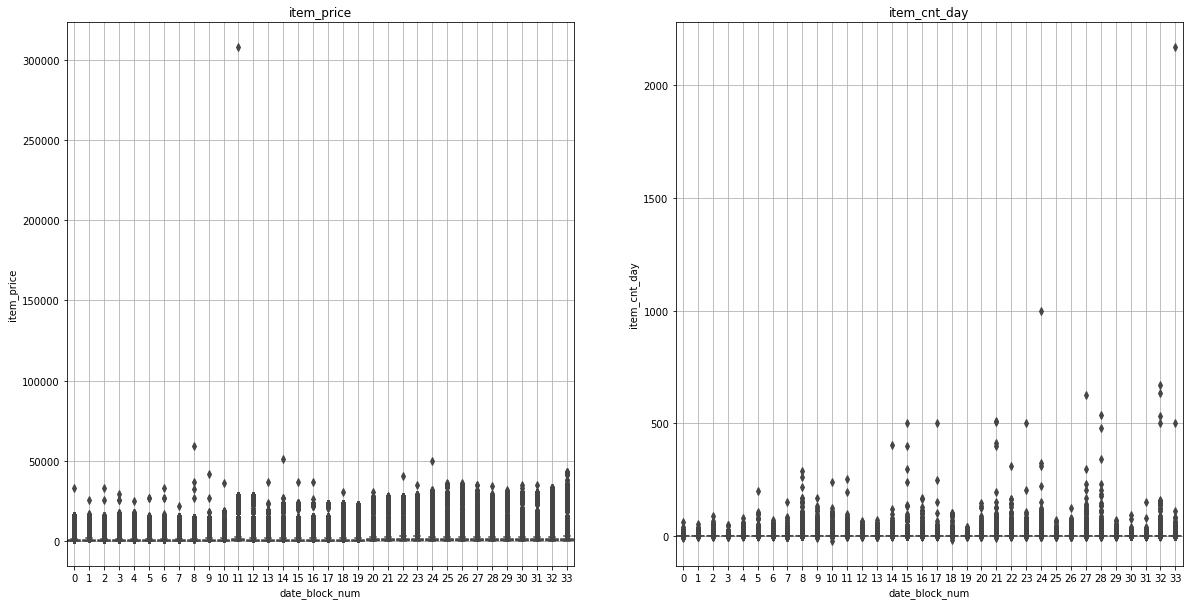

In [20]:
def price_item_cnt_day_boxplot():
    plt.figure(figsize = (20,10))
    # item_price 의 박스플롯
    plt.subplot(1,2,1)
    sns.boxplot(x = 'date_block_num' , y= 'item_price',data =train)
    plt.title('item_price')
    plt.grid()
    # item_cnt_day의 박스 플롯
    plt.subplot(1,2,2)
    sns.boxplot(x = 'date_block_num' , y= 'item_cnt_day',data =train)
    plt.title('item_cnt_day')
    plt.grid()
price_item_cnt_day_boxplot()

- 다음은 date_block_num 별로 item_price의 boxplot이다.  
- 위의 그래프를 기준으로 item_price는 50000 이상 , item_cnt_day 는 1000 이상을 이상치로서 train에서 제거한다.  
- 또한 판매되는 수량을 구하는 것이 목적이므로 0미만의 값을 제거한다.

In [21]:
condition_for_drop = ((train["item_price"] >= 50000) | (train["item_price"] < 0))
train.drop(train[condition_for_drop].index, axis = 0 , inplace=True)

condition_for_drop = ((train["item_cnt_day"] >= 1000) | (train["item_cnt_day"] < 0))
train.drop(train[condition_for_drop].index, axis = 0 , inplace=True)

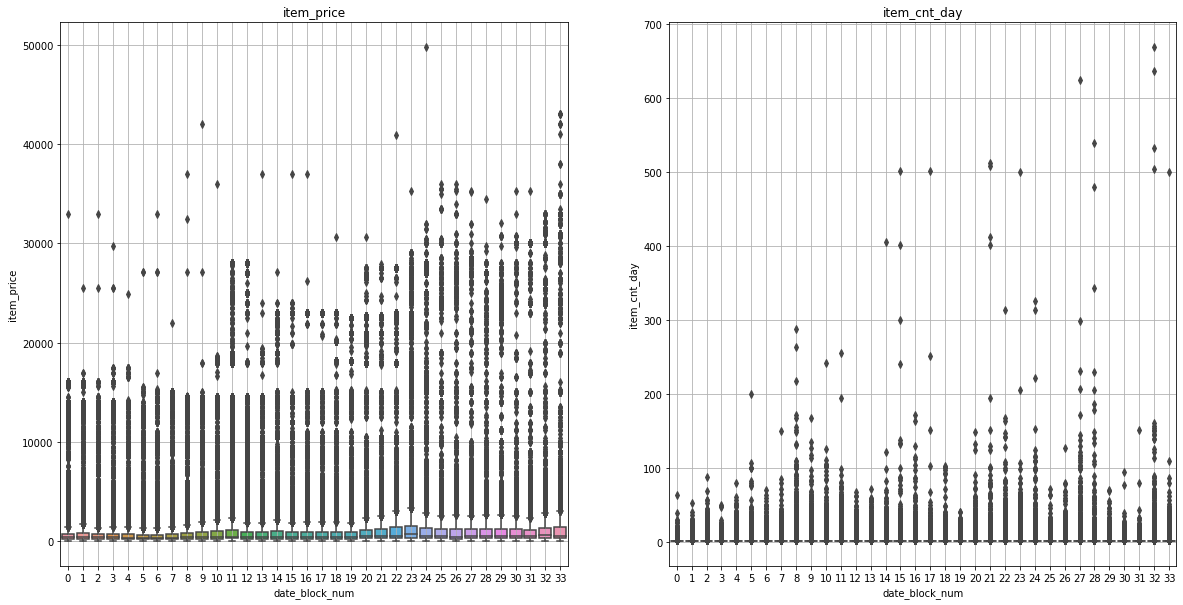

In [22]:
# 제거 후의 boxplot
price_item_cnt_day_boxplot()

### train 에만 존재하는 가게 지우기 

In [23]:
train = train[~train['shop_id'].isin(diff_train_test_shop_id)]

### test 모든 가게에 대해 파는 아이템 조합

In [24]:
'''
방법 1
itertools 의 product을 사용하여
각 달 아이템이 팔린 가게와 아이템 , data_num_block의 조합을 출력한다. 
'''

temp_train = []
for i in range(34):
    all_shops = train.loc[train['date_block_num'] == i , 'shop_id'].unique()
    all_items = train.loc[train['date_block_num'] == i , 'item_id'].unique()
    temp_train.append(np.array(list(product([i] , all_shops ,all_items))))
base_features_names = ['date_block_num','shop_id' , 'item_id']
# np.vstack 세로 결합 (열의 갯수가 같아야 한다.)
temp_train = pd.DataFrame(np.vstack(temp_train) , columns = base_features_names)

In [25]:
'''
doing
item_cnt_day >> item_cnt_month 
'''
train_item_cnt_month  = train.pivot_table(index = base_features_names ,
                                          values = 'item_cnt_day' , 
                                          aggfunc = np.sum)
temp_train = pd.merge(temp_train,train_item_cnt_month.reset_index(),on = base_features_names,how= 'left')

temp_train.rename(columns= {'item_cnt_day':'item_cnt_month'} ,inplace = True)

In [26]:
'''
doing
item_price  >> item_price_mean_month
adding
item_count
'''
train_item_cnt_month  = train.pivot_table(index = base_features_names ,
                                          values = ['item_cnt_day' , 'item_price'] , 
                                          aggfunc = {'item_cnt_day':'count' ,'item_price' :np.mean})
temp_train = pd.merge(temp_train,train_item_cnt_month.reset_index(),on = base_features_names,how= 'left')
temp_train.rename(columns= {'item_cnt_day':'item_count' ,'item_price' :'item_price_mean_month'} 
                  ,inplace = True)
temp_train.fillna(0 , inplace = True)
temp_train.head()

,date_block_num,shop_id,item_id,item_cnt_month,item_count,item_price_mean_month
0,0,59,22154,1.0,1.0,999.0
1,0,59,2552,0.0,0.0,0.0
2,0,59,2554,0.0,0.0,0.0
3,0,59,2555,0.0,0.0,0.0
4,0,59,2564,0.0,0.0,0.0


In [27]:
temp_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8642761 entries, 0 to 8642760
Data columns (total 6 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   date_block_num         int64  
 1   shop_id                int64  
 2   item_id                int64  
 3   item_cnt_month         float64
 4   item_count             float64
 5   item_price_mean_month  float64
dtypes: float64(3), int64(3)
memory usage: 461.6 MB


## items

In [28]:
items.info() # 결측값은 없고 데이터 타입이 적당함을 알수있다.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22170 entries, 0 to 22169
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   item_name         22170 non-null  object
 1   item_id           22170 non-null  int64 
 2   item_category_id  22170 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 519.7+ KB


In [29]:
items.head(20)

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40
5,***НОВЫЕ АМЕРИКАНСКИЕ ГРАФФИТИ (UNI) ...,5,40
6,***УДАР ПО ВОРОТАМ (UNI) D,6,40
7,***УДАР ПО ВОРОТАМ-2 (UNI) D,7,40
8,***ЧАЙ С МУССОЛИНИ D,8,40
9,***ШУГАРЛЭНДСКИЙ ЭКСПРЕСС (UNI) D,9,40


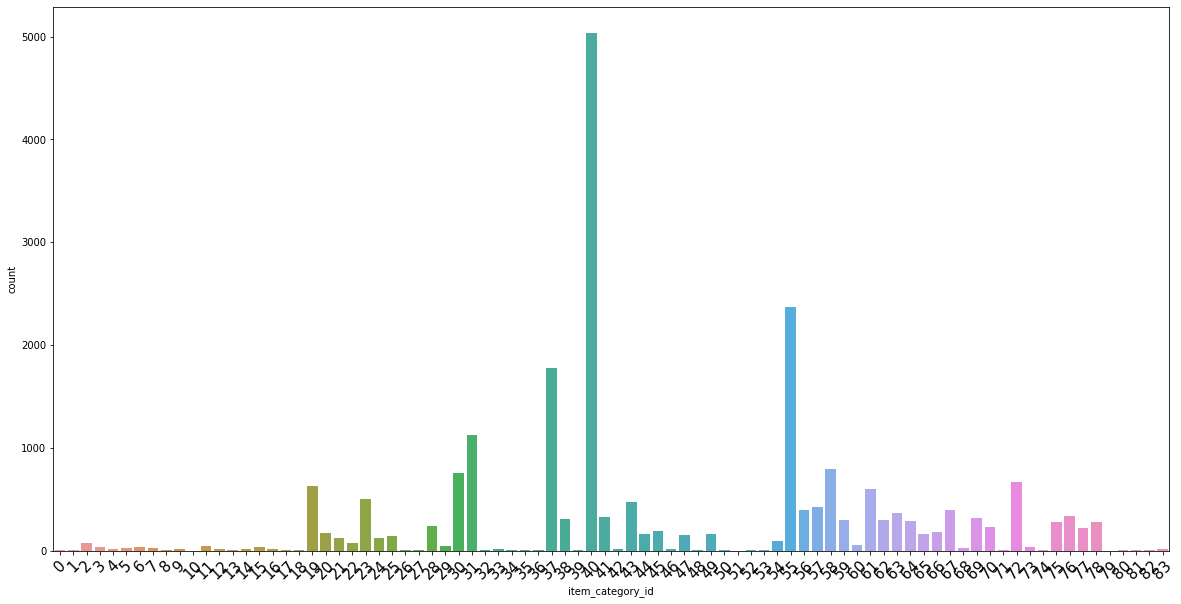

In [30]:
plt.figure(figsize=(20,10))
sns.countplot(x= 'item_category_id' , data = items)
plt.xticks(size = 15 , rotation =  45 , color = 'black')
plt.show()

In [31]:
item_categories[item_categories['item_category_id']==40]

,item_category_name,item_category_id
40,Кино - DVD,40


- 특정 카테고리에 아이템이 몰려 있는 것을 확인 할 수 있다. 
- 이를 해결하기 위해 상위 카테고리를 분리 후 데이터가 수가 작은 카테고리는 기타 카테고리에 묶는 작업이 필요하다.

## item_category

In [32]:
item_categories.info()  # 결측값은 없고 데이터 타입이 적당함을 알수있다.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   item_category_name  84 non-null     object
 1   item_category_id    84 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.4+ KB


In [33]:
item_categories.head(20)

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4
5,Аксессуары - PSVita,5
6,Аксессуары - XBOX 360,6
7,Аксессуары - XBOX ONE,7
8,Билеты (Цифра),8
9,Доставка товара,9


- item_category_name에 같은 단어가 들어가는 데이터가 많이 존재한다
- 이를 묶어 더 큰 범주를 만들 수 있다.

## high_category

item_category의 앞부분만 자르고 새롭게 만든 열을 라벨인코딩 (악세사리 >> 1)   
item_id와 연결되어있는 item_category를 새롭게 만든 열로 연결하여 test값을 예측한다면?

In [34]:
# item_category 분류하여 새로운 열 만들기
def make_high_category(data_name_col):
    '''
    상위 분류를 생성후 라벨 인코딩을 하는 함수
    shopname 과 item_category_name 에 사용
    '''
    data_name_col
    data_name_col = data_name_col.apply(clean_text)
    high_category_name = data_name_col.str.split(' ')
    high_category_name = [data[1] if data[0] == '' else data[0] for data in high_category_name]
    high_category_name_le = LabelEncoder()
    high_category_name_le.fit(high_category_name)
    high_category_id = high_category_name_le.transform(high_category_name)
    return high_category_name , high_category_id

### 아이템 상위 카테고리 high_category_name

In [35]:
item_categories['high_category_name'] , item_categories['high_category_id'] =\
make_high_category(item_categories.item_category_name)

In [36]:
item_categories_value_counts=item_categories['high_category_name'].value_counts()
print(item_categories_value_counts)
item_categories_value_counts = item_categories_value_counts[item_categories['high_category_name'].value_counts()<5].index

Игры          14
Книги         13
Подарки       12
Игровые        8
Аксессуары     7
Музыка         6
Программы      6
Карты          5
Кино           5
Служебные      2
Чистые         2
PC             1
Билеты         1
Доставка       1
Элементы       1
Name: high_category_name, dtype: int64


In [37]:
# 아이템 종류가 5개 미만인 상위 카테고리는 etc로 묶어준다.

In [38]:
item_categories['high_category_name'] = \
item_categories['high_category_name'].apply(lambda x : 'etc' if x in item_categories_value_counts else x)

In [39]:
item_categories['high_category_name'].value_counts()

Игры          14
Книги         13
Подарки       12
etc            8
Игровые        8
Аксессуары     7
Музыка         6
Программы      6
Карты          5
Кино           5
Name: high_category_name, dtype: int64

### shop 상위 카테고리 city

In [40]:
shops['city_name'],shops['city_id'] = make_high_category(shops.shop_name)

In [41]:
shops.head(3)

,shop_name,shop_id,city_name,city_id
0,"!Якутск Орджоникидзе, 56 фран",0,Якутск,29
1,"!Якутск ТЦ ""Центральный"" фран",1,Якутск,29
2,"Адыгея ТЦ ""Мега""",2,Адыгея,0


## train + test 

In [42]:
'''
test에 없는 열을 추가 해야 하거나
train에 쓸모없는 데이터를 제거해야 한다. 
'''
test.columns , temp_train.columns

(Index(['ID', 'shop_id', 'item_id'], dtype='object'),
 Index(['date_block_num', 'shop_id', 'item_id', 'item_cnt_month', 'item_count',
        'item_price_mean_month'],
       dtype='object'))

In [43]:
test['date_block_num'] = 34

del test['ID']

In [44]:
test.columns , temp_train.columns

(Index(['shop_id', 'item_id', 'date_block_num'], dtype='object'),
 Index(['date_block_num', 'shop_id', 'item_id', 'item_cnt_month', 'item_count',
        'item_price_mean_month'],
       dtype='object'))

In [45]:
# 인덱스 값이 꼬여있다.
pd.concat([test,temp_train]).fillna(0)

,shop_id,item_id,date_block_num,item_cnt_month,item_count,item_price_mean_month
0,5,5037,34,0.0,0.0,0.0
1,5,5320,34,0.0,0.0,0.0
2,5,5233,34,0.0,0.0,0.0
3,5,5232,34,0.0,0.0,0.0
4,5,5268,34,0.0,0.0,0.0
...,...,...,...,...,...,...
8642756,21,7635,33,0.0,0.0,0.0
8642757,21,7638,33,0.0,0.0,0.0
8642758,21,7640,33,0.0,0.0,0.0
8642759,21,7632,33,0.0,0.0,0.0


In [46]:
pd.concat([test,temp_train]).fillna(0).sort_values('date_block_num').reset_index().drop('index',axis = 1)

,shop_id,item_id,date_block_num,item_cnt_month,item_count,item_price_mean_month
0,35,9613,0,0.0,0.0,0.0
1,7,9978,0,0.0,0.0,0.0
2,7,10055,0,0.0,0.0,0.0
3,7,11165,0,0.0,0.0,0.0
4,7,8075,0,0.0,0.0,0.0
...,...,...,...,...,...,...
8856956,57,16188,34,0.0,0.0,0.0
8856957,57,18454,34,0.0,0.0,0.0
8856958,57,18027,34,0.0,0.0,0.0
8856959,57,1041,34,0.0,0.0,0.0


In [47]:
sales_df = pd.concat([test,temp_train]).fillna(0).sort_values('date_block_num').reset_index().drop('index',axis = 1)

## merging item , city data

In [48]:
sales_df = pd.merge(sales_df ,shops ,on =  'shop_id').drop(['shop_name','city_name'] ,axis =1)

In [49]:
sales_df.head(3)

,shop_id,item_id,date_block_num,item_cnt_month,item_count,item_price_mean_month,city_id
0,35,9613,0,0.0,0.0,0.0,15
1,35,4148,0,0.0,0.0,0.0,15
2,35,4128,0,1.0,1.0,899.0,15


In [50]:
item_high_categories = items.merge(item_categories).drop(['item_name','item_category_name','high_category_name'],axis = 1)
item_high_categories.head(3)

,item_id,item_category_id,high_category_id
0,0,40,7
1,2,40,7
2,3,40,7


In [51]:
sales_df = pd.merge(sales_df ,item_high_categories ,on =  'item_id')

### add item_revenue_month

In [52]:
sales_df['item_revenue_month'] = sales_df.item_cnt_month * sales_df.item_price_mean_month

In [53]:
sales_df.head(3)

,shop_id,item_id,date_block_num,item_cnt_month,item_count,item_price_mean_month,city_id,item_category_id,high_category_id,item_revenue_month
0,35,9613,0,0.0,0.0,0.0,15,37,7,0.0
1,35,9613,1,0.0,0.0,0.0,15,37,7,0.0
2,35,9613,2,0.0,0.0,0.0,15,37,7,0.0


### add_month

In [54]:
sales_df['month'] = ((sales_df.date_block_num % 12) +1).astype(np.int8)

## 시각화

In [55]:
def draw_x_group_y_sum_barplot(x, y):
    temp_data_for_plot = \
    sales_df.pivot_table(index = x , values = y , aggfunc = np.sum).reset_index()
    plt.figure(figsize=(20,20))
    sns.barplot(x= x,
                y = y, 
                data = temp_data_for_plot)
    plt.title(f'{y}___per___{x}')
    plt.rc.fontsize = 20
    plt.show()

### date_block_num 별 팔린 횟수

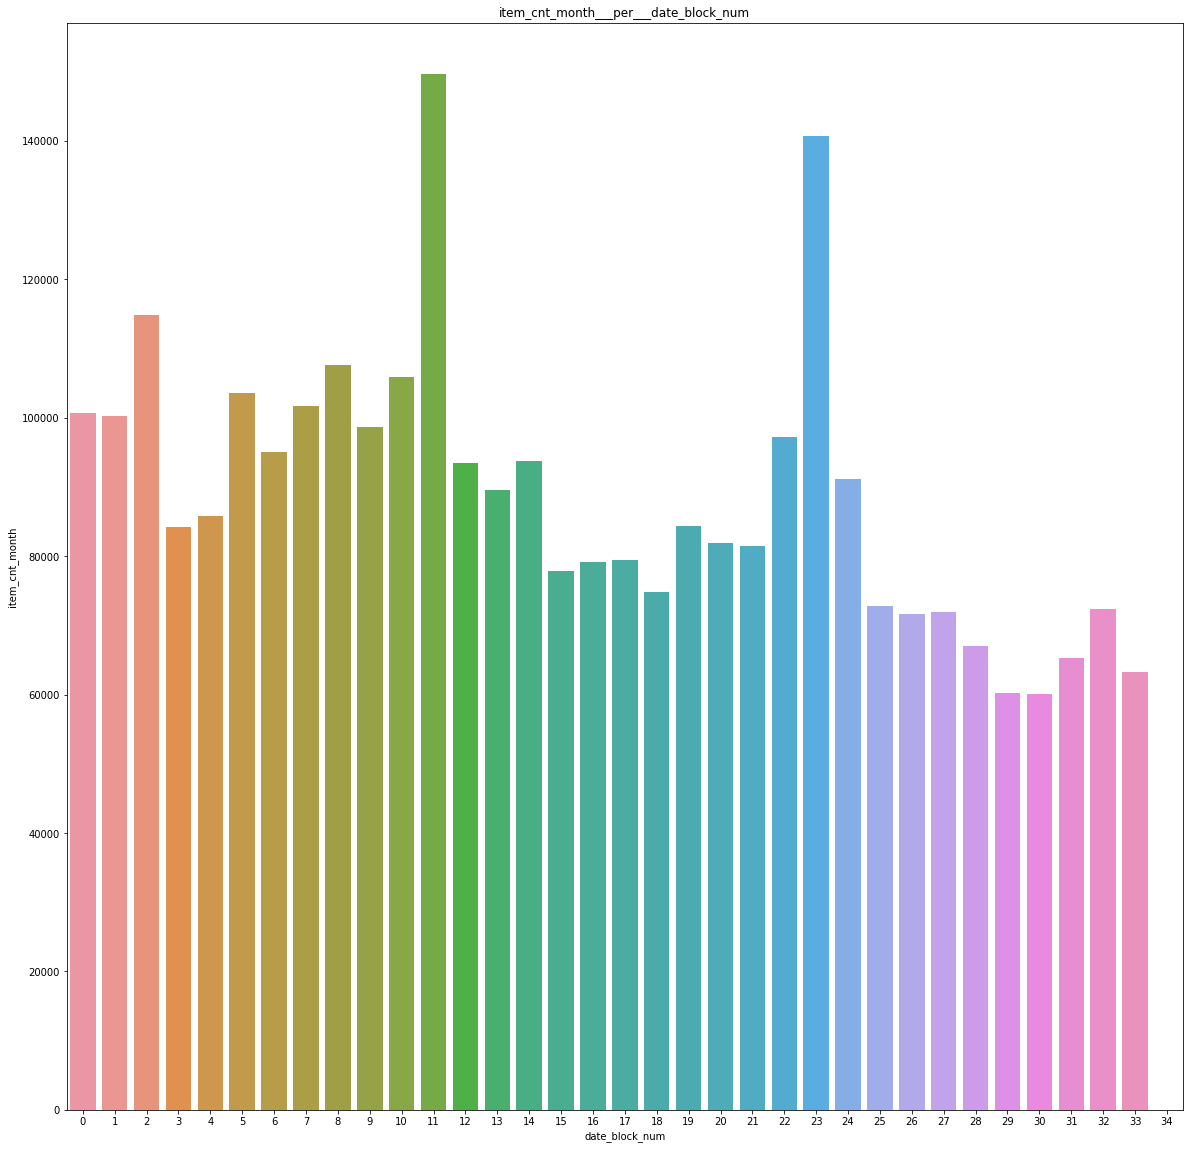

In [56]:
draw_x_group_y_sum_barplot('date_block_num','item_cnt_month')

### 달별 팔린 횟수 

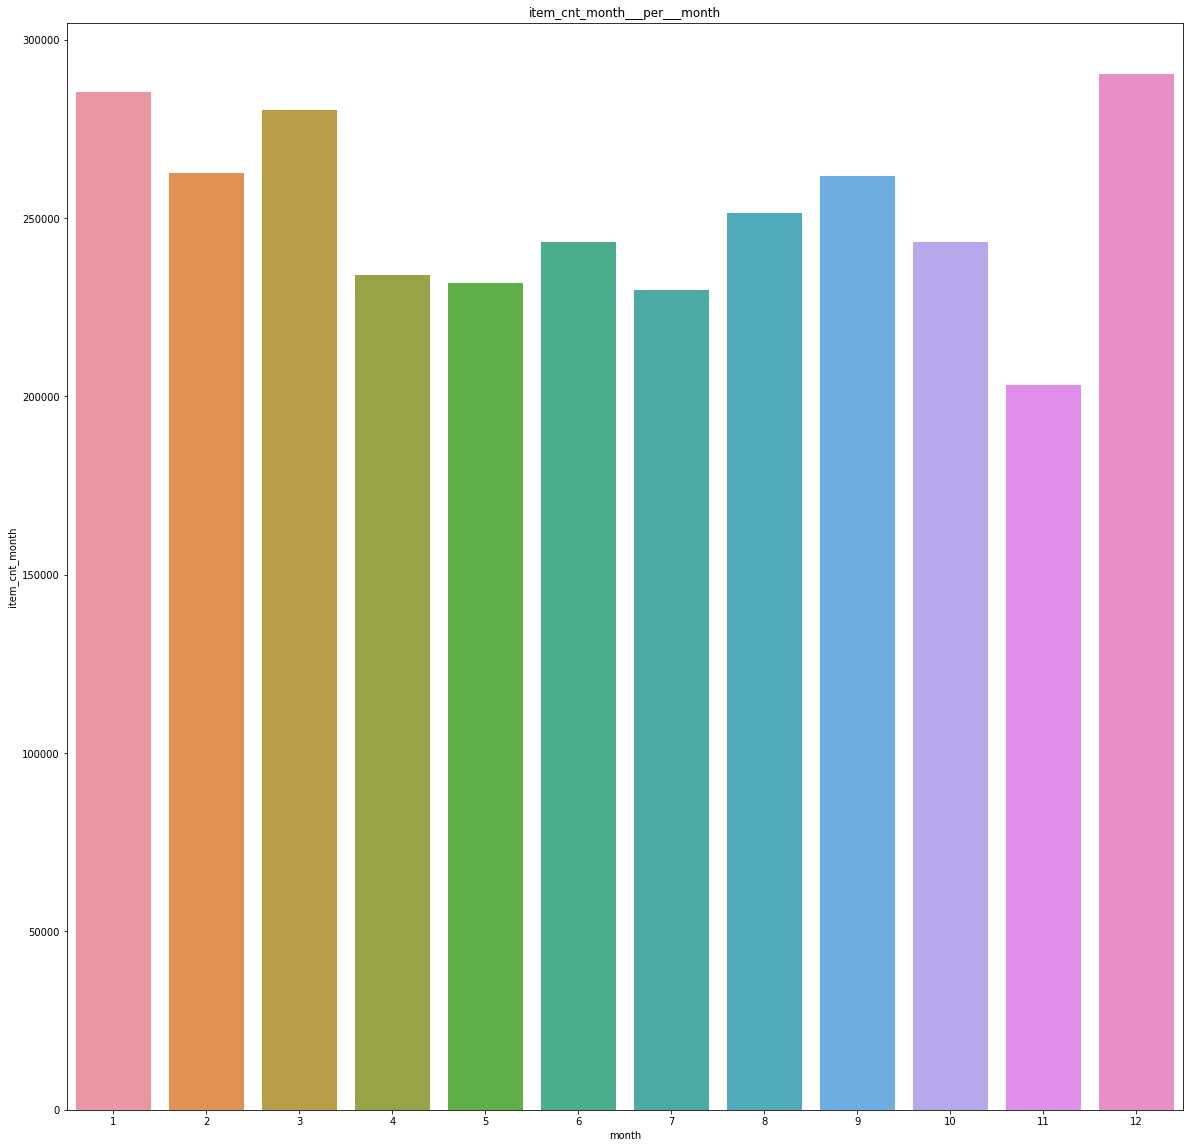

In [57]:
draw_x_group_y_sum_barplot('month','item_cnt_month')

In [58]:
def draw_x_group_y_sum_regplot(x, y):
    plt.figure(figsize=(20,20))
    sns.regplot(x= x,
                y = y, 
                data = sales_df)
    plt.title(f'{y}___per___{x}')
    plt.rc.fontsize = 20
    plt.show()

## add_mean_feature

In [59]:
def add_mean_feature(df , base_feature_names ,num_feature_names ,mean_feature_names ):
    '''
    base_feature_name를 기준으로 mean_feature_names의 값들을 
    한달 평균을 구해서 df에 병합해주는 함수
    '''
    df_pivot  = df[list(base_feature_names) + list(num_feature_names)]
    col_name_front = ''
    for base_feature_name in base_feature_names:
        if base_feature_name !='date_block_num':
            col_name_front += '_'.join(base_feature_name.split('_')[:-1])+'_'

    for num_feature_name in num_feature_names:
        col_name = col_name_front+num_feature_name.split('_')[1]+'_month_mean'
        df_pivot = df_pivot.rename(columns = {num_feature_name:col_name})
        print(f'{col_name}이 생성되었습니다.')
        mean_feature_names.append(col_name)

    df_pivot = df_pivot.pivot_table(index = base_feature_names)
    df = df.merge(df_pivot , on =base_feature_names)
    return df , mean_feature_names

In [60]:
base_feature_names = ['date_block_num','shop_id','item_id']
base_item_feature_names = ['item_id','item_category_id','high_category_id']
base_place_feature_names = ['shop_id','city_id']
catagory_feature_names = list(set(base_feature_names + base_item_feature_names + base_place_feature_names+["month"]))
base_item_feature_names = ['high_category_id']
base_place_feature_names = ['city_id']
num_feature_names = ['item_cnt_month','item_revenue_month','item_count']
mean_feature_names = []

In [61]:
for place in base_place_feature_names:
    for item in base_item_feature_names:
        base_feature_names = ['date_block_num', place,item]
        sales_df,mean_feature_names = add_mean_feature(sales_df ,base_feature_names,num_feature_names,mean_feature_names)

city_high_category_cnt_month_mean이 생성되었습니다.
city_high_category_revenue_month_mean이 생성되었습니다.
city_high_category_count_month_mean이 생성되었습니다.


In [62]:
sales_df.columns

Index(['shop_id', 'item_id', 'date_block_num', 'item_cnt_month', 'item_count',
       'item_price_mean_month', 'city_id', 'item_category_id',
       'high_category_id', 'item_revenue_month', 'month',
       'city_high_category_cnt_month_mean',
       'city_high_category_count_month_mean',
       'city_high_category_revenue_month_mean'],
      dtype='object')

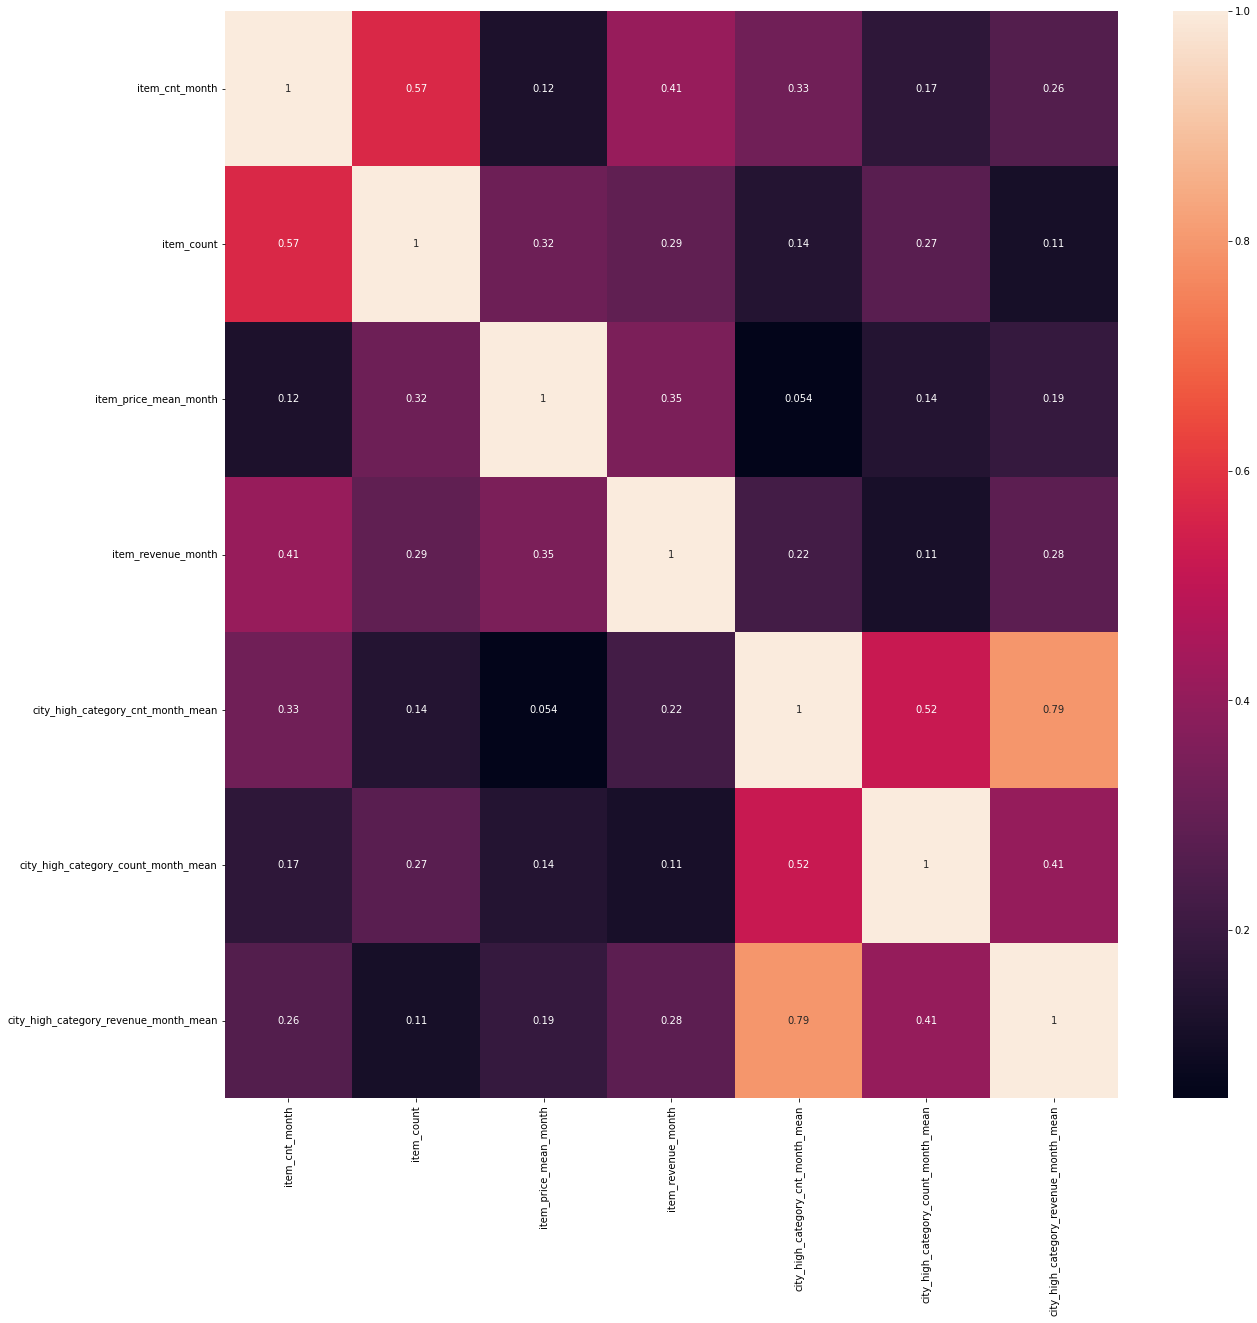

In [63]:
sales_corr = sales_df.drop(columns = catagory_feature_names).corr() 
plt.figure(figsize=(20,20))
sns.heatmap(sales_corr, annot=True)
plt.show()

In [64]:
def find_high_corr_location(df_corr , threshold = 0.9):
    cols = df_corr.columns
    high_corr_location = []
    for col in cols :
        for index in cols:
            df_corr_data = [index,col,df_corr.loc[index,col]]
            df_corr_data_2 = [col,index,df_corr.loc[col,index]]
            if (df_corr_data[2] >threshold ) &  (index != col) &(df_corr_data_2 not in high_corr_location):
                high_corr_location.append(df_corr_data)
                print(f'{df_corr_data[0]}와{df_corr_data[1]}는 {df_corr_data[2]}의 상관계수를 가집니다.\n')
    return high_corr_location
        

In [65]:
find_high_corr_location(sales_df.drop(columns = catagory_feature_names).corr() ,0.9)

[]

In [67]:
# drop_names =\
# ['shop_item_cnt_month_mean',
#  'shop_item_count_month_mean',
#  'shop_item_revenue_month_mean',
#  'shop_item_category_count_month_mean',
#  'shop_item_category_revenue_month_mean',
#  'shop_high_category_cnt_month_mean',
#  'shop_high_category_revenue_month_mean',
# 'city_item_cnt_month_mean',
# 'city_item_revenue_month_mean']
# sales_df.drop(columns = drop_names ,axis =1)
# mean_feature_names = list(set(mean_feature_names) - set(drop_names))

In [70]:
# sales_df = sales_df.drop(columns = drop_names)

In [71]:
sales_df  =reduce_mem_usage(sales_df)

Mem. usage decreased to 287.19 Mb (0.0% reduction)


In [72]:
sales_df.dtypes

shop_id                                     int8
item_id                                    int16
date_block_num                              int8
item_cnt_month                           float16
item_count                               float16
item_price_mean_month                    float16
city_id                                     int8
item_category_id                            int8
high_category_id                            int8
item_revenue_month                       float32
month                                       int8
city_high_category_cnt_month_mean        float16
city_high_category_count_month_mean      float16
city_high_category_revenue_month_mean    float32
dtype: object

In [73]:
sales_df.T

,0,1,2,3,4,5,6,7,8,9,...,8856951,8856952,8856953,8856954,8856955,8856956,8856957,8856958,8856959,8856960
shop_id,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,...,36.0,12.0,47.0,50.0,49.0,56.0,59.0,5.0,55.0,48.0
item_id,9613.000000,1273.000000,1112.000000,8155.000000,8147.000000,8096.000000,8093.000000,8092.000000,7709.000000,5527.000000,...,5441.0,5441.0,5441.0,5441.0,5441.0,5441.0,5441.0,5441.0,5441.0,5441.0
date_block_num,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,34.0,34.0,34.0,34.0,34.0,34.0,34.0,34.0,34.0,34.0
item_cnt_month,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
item_count,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
item_price_mean_month,0.000000,0.000000,0.000000,0.000000,0.000000,379.000000,1329.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
city_id,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,...,16.0,7.0,22.0,24.0,24.0,28.0,30.0,3.0,27.0,23.0
item_category_id,37.000000,37.000000,37.000000,38.000000,40.000000,40.000000,38.000000,40.000000,40.000000,40.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
high_category_id,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
item_revenue_month,0.000000,0.000000,0.000000,0.000000,0.000000,379.000000,2657.800049,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# add_lag_data

In [74]:
mean_feature_names

['city_high_category_cnt_month_mean',
 'city_high_category_revenue_month_mean',
 'city_high_category_count_month_mean']

In [75]:
def add_lag_data(df , base_feature_names, lag_feature,lag_feature_names, lag_period=3):
    df_temp = df.loc[:, base_feature_names + [lag_feature]].copy()
    for i in range(1,lag_period+1):
        col_name  = lag_feature +"_lag_"+f'{i}'
        lag_feature_names.append(col_name)
        df_temp['date_block_num'] +=i
        df_temp.columns = base_feature_names +[col_name]
        df_temp = df.loc[:,base_features_names].merge(df_temp.drop_duplicates(), 
                      on=base_feature_names, 
                      how='left')
        df_temp = df_temp.set_index(base_feature_names)
        df = df.set_index(base_feature_names)
        df[lag_feature].fillna(0)
        print(f'{col_name}을 생성하였습니다.')
    return df ,lag_feature_names
        
    

In [78]:
# lag_feature_names = []
# for lag_feature in (mean_feature_names + num_feature_names):
#     sales_df,lag_feature_names = add_lag_data(sales_df,base_feature_names,lag_feature,lag_feature_names)

In [79]:
sales_df.columns

Index(['shop_id', 'item_id', 'date_block_num', 'item_cnt_month', 'item_count',
       'item_price_mean_month', 'city_id', 'item_category_id',
       'high_category_id', 'item_revenue_month', 'month',
       'city_high_category_cnt_month_mean',
       'city_high_category_count_month_mean',
       'city_high_category_revenue_month_mean'],
      dtype='object')

# Holdsout

In [80]:
sales_df = reduce_mem_usage(sales_df)
x_train = sales_df[sales_df['date_block_num'] < 33]
x_train = x_train.drop(['item_cnt_month'], axis = 1)
y_train = sales_df[sales_df['date_block_num'] < 33]['item_cnt_month']


x_valid = sales_df[sales_df['date_block_num'] == 33]
x_valid = x_valid.drop(['item_cnt_month'], axis = 1)
y_valid = sales_df[sales_df['date_block_num'] == 33]['item_cnt_month']

x_test = sales_df[sales_df['date_block_num'] == 34]
x_test = x_test.drop(['item_cnt_month'], axis = 1)
y_test = sales_df[sales_df['date_block_num'] == 34]['item_cnt_month']

Mem. usage decreased to 545.19 Mb (0.0% reduction)


# XGboost

In [81]:
# Model
import gc
import pickle
from xgboost import XGBRegressor
from matplotlib.pylab import rcParams

In [82]:
# Training
model = XGBRegressor(
    max_depth=10,
    n_estimators=1000,
    min_child_weight=0.5, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.1,
    seed=42)

model.fit(
    x_train, 
    y_train, 
    eval_metric="rmse", 
    eval_set=[(x_train, y_train), (x_valid, y_valid)], 
    verbose=True, 
    early_stopping_rounds = 20)

rcParams['figure.figsize'] = 12, 4

/opt/homebrew/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:3.20721	validation_1-rmse:2.43498
[1]	validation_0-rmse:2.94905	validation_1-rmse:2.22666
[2]	validation_0-rmse:2.71502	validation_1-rmse:2.04824
[3]	validation_0-rmse:2.50216	validation_1-rmse:1.87589
[4]	validation_0-rmse:2.31160	validation_1-rmse:1.72062
[5]	validation_0-rmse:2.14194	validation_1-rmse:1.58177
[6]	validation_0-rmse:1.98189	validation_1-rmse:1.45652
[7]	validation_0-rmse:1.86489	validation_1-rmse:1.38894
[8]	validation_0-rmse:1.73392	validation_1-rmse:1.29773
[9]	validation_0-rmse:1.61997	validation_1-rmse:1.23411
[10]	validation_0-rmse:1.52225	validation_1-rmse:1.15930
[11]	validation_0-rmse:1.42729	validation_1-rmse:1.11347
[12]	validation_0-rmse:1.34121	validation_1-rmse:1.06196
[13]	validation_0-rmse:1.26034	validation_1-rmse:1.02127
[14]	validation_0-rmse:1.18824	validation_1-rmse:0.97933
[15]	validation_0-rmse:1.12206	validation_1-rmse:0.94337
[16]	validation_0-rmse:1.07466	validation_1-rmse:0.91157
[17]	validation_0-rmse:1.02227	validation

In [83]:
# Testing
Y_pred = model.predict(x_valid).clip(0, 20)
Y_test = model.predict(x_test).clip(0, 20)

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test
})
submission.to_csv('submission.csv', index=False)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

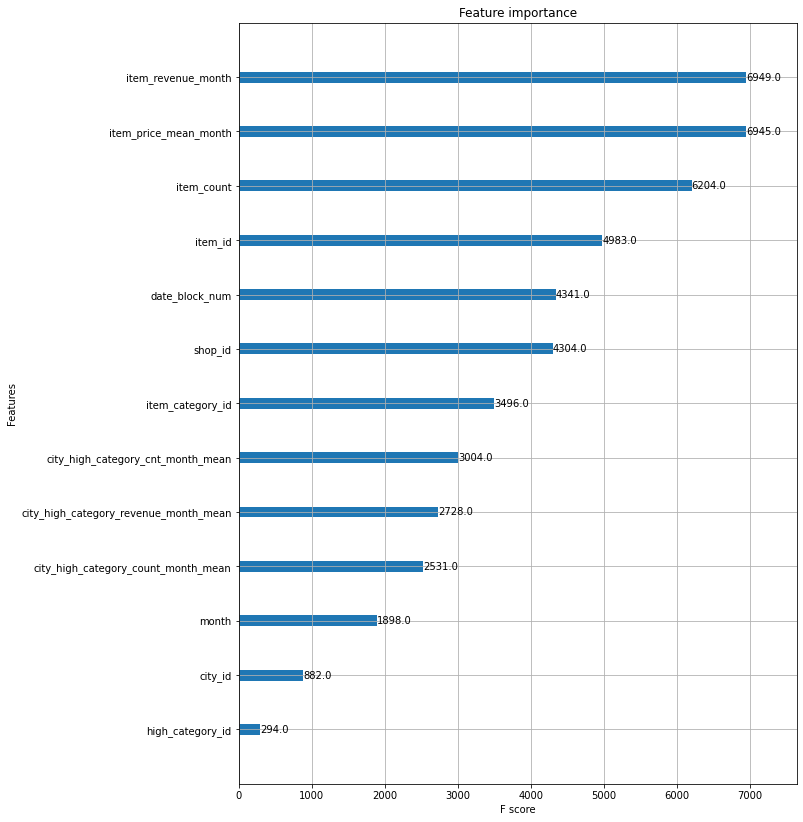

In [84]:
# Plot feature importance
from xgboost import plot_importance
def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)
plot_features(model, (10,14))